In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import datetime as dt
import urllib.request
import json
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
data_source = 'alphavantage'
tick = "AMZN"

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # TCS stock market prices
    ticker = tick

    # JSON file with all the stock market data for TCS
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s" % (
        ticker, api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv' % ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(
                columns=['Date', 'Low', 'High', 'Close', 'Open'])
            for k, v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(), float(v['3. low']), float(v['2. high']),
                            float(v['4. close']), float(v['1. open'])]
                df.loc[-1, :] = data_row
                df.index = df.index + 1
        print('Data saved to : %s' % file_to_save)
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)


File already exists. Loading data from CSV


In [3]:
file_name = "stock_market_data-" + tick + ".csv"
df = pd.read_csv(file_name)

df = df[['Date', 'Open', 'Close', 'Low', 'High']]

df = df.sort_values('Date')

high_prices = df.loc[:, 'High']
low_prices = df.loc[:, 'Low']
df["Mid Prices"] = (high_prices + low_prices) / 2.0


In [4]:
df.head()

,Date,Open,Close,Low,High,Mid Prices
5259,1998-01-02,60.00,59.50,57.56,60.00,58.780
5258,1998-01-05,58.63,57.00,56.50,59.25,57.875
5257,1998-01-06,56.38,58.06,56.00,58.50,57.250
5256,1998-01-07,58.00,57.38,56.31,58.00,57.155
5255,1998-01-08,56.38,55.38,54.38,56.44,55.410


In [5]:
df.tail()

,Date,Open,Close,Low,High,Mid Prices
4,2018-11-19,1577.01,1512.29,1503.36,1581.19,1542.275
3,2018-11-20,1437.50,1495.46,1420.00,1534.75,1477.375
2,2018-11-21,1542.99,1516.73,1515.00,1550.00,1532.500
1,2018-11-23,1517.00,1502.06,1501.81,1536.20,1519.005
0,2018-11-26,1539.00,1581.33,1524.22,1584.81,1554.515


In [6]:
df.drop("Date", axis=1, inplace=True)

Most recent 2018-11-23

In [7]:
df.tail()

,Open,Close,Low,High,Mid Prices
4,1577.01,1512.29,1503.36,1581.19,1542.275
3,1437.50,1495.46,1420.00,1534.75,1477.375
2,1542.99,1516.73,1515.00,1550.00,1532.500
1,1517.00,1502.06,1501.81,1536.20,1519.005
0,1539.00,1581.33,1524.22,1584.81,1554.515


In [8]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.75 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, -1]

    x_train = np.reshape(
        x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(
        x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]


In [9]:
df1 = df
df = df.values

In [10]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [11]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)

In [12]:
X_train.shape

(3940, 5, 5)

In [13]:
x_latest = df[-5:]

In [14]:
x_latest = np.reshape(x_latest, (1, x_latest.shape[0], window))

In [15]:
df1.describe()

,Open,Close,Low,High,Mid Prices
count,5260.000000,5260.000000,5260.000000,5260.000000,5260.000000
mean,263.410676,263.370409,259.887271,266.583351,263.235311
std,385.650533,385.262014,381.286909,388.985337,385.120210
min,5.910000,5.970000,5.510000,6.100000,5.805000
25%,41.467500,41.622500,40.850000,42.500000,41.653750
50%,92.525000,92.390000,90.335000,94.490000,92.647500
75%,298.205000,297.997500,295.260000,301.810000,298.361250
max,2038.110000,2039.510000,2013.000000,2050.500000,2031.750000


In [16]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=25,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print('compilation time : ', time.time() - start)
    return model


In [17]:
model = build_model([5, window, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=25,
    validation_split=0.1,
    verbose=1)

compilation time :  0.020708322525024414
Train on 3546 samples, validate on 394 samples
Epoch 1/25
3546/3546 [==============================] - 1s 412us/step - loss: 7.3342e-04 - val_loss: 0.0021
Epoch 2/25
3546/3546 [==============================] - 0s 82us/step - loss: 2.5914e-04 - val_loss: 0.0011
Epoch 3/25
3546/3546 [==============================] - 0s 78us/step - loss: 9.3110e-05 - val_loss: 6.3104e-05
Epoch 4/25
3546/3546 [==============================] - 0s 85us/step - loss: 1.2802e-04 - val_loss: 2.3485e-04
Epoch 5/25
3546/3546 [==============================] - 0s 86us/step - loss: 7.2795e-05 - val_loss: 5.0874e-05
Epoch 6/25
3546/3546 [==============================] - 0s 79us/step - loss: 9.0717e-05 - val_loss: 1.9059e-04
Epoch 7/25
3546/3546 [==============================] - 0s 82us/step - loss: 7.8009e-05 - val_loss: 3.4712e-05
Epoch 8/25
3546/3546 [==============================] - 0s 78us/step - loss: 7.5800e-05 - val_loss: 1.4463e-04
Epoch 9/25
3546/3546 [=========

In [18]:
trainScore = model.evaluate(X_train, y_train, verbose=0)

# Predictions

p = model.predict(X_test)

mse_scaled = mean_squared_error(y_test, p)

# in case want to display accuracy use
# return(p, y_test, accuracy_train, accuracy_test)
p = np.reshape(p, p.shape[0]).tolist()
y_test = np.reshape(y_test, y_test.shape[0]).tolist()

def delete_stock_data(file_name):
    if os.path.exists(file_name):
        os.remove(file_name)
        print("File removed successfully")
    else:
        print("The file does not exist")

# delete_stock_data(file_name)

In [19]:
trainScore

2.383506445021524e-05

In [20]:
print(mse_scaled)

0.0008234004644287568


In [21]:
p_latest = model.predict(x_latest)
p.append(p_latest[0,0])

In [22]:
def inverse_minmax(x, maxval, minval):
    return (x*(maxval-minval)+minval)

In [23]:
maxval = max(df1['Mid Prices'])
minval = min(df1['Mid Prices'])

In [24]:
p = [inverse_minmax(y, maxval, minval) for y in p]
y_test = [inverse_minmax(y, maxval, minval) for y in y_test]

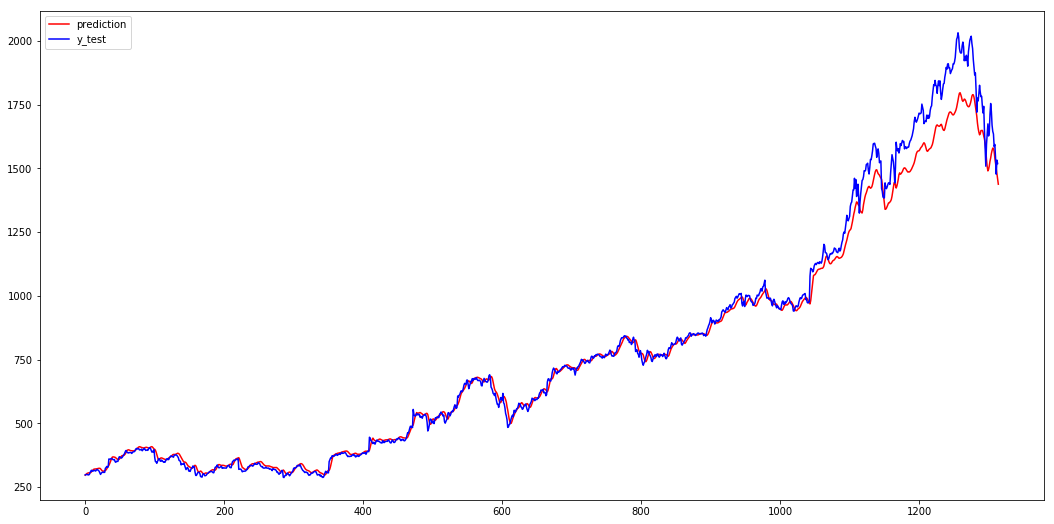

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [26]:
from math import sqrt
mse = mean_squared_error(y_test, p[:-1])
rmse = sqrt(mse)
print (rmse)

58.13440138328471
